## Importing the libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy 

import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score 

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError, RootMeanSquaredError, R2Score

import copy

In [2]:
os.chdir('C:/Users/prach/OneDrive - Singapore Management University/Documents/Term 5/Applied Machine Learning/Project')

### Splitting the dataset into train, validation and test sets

In [3]:
cars_coded = pd.read_csv("used_cars_data/cars_coded.csv", nrows = 750000)

In [4]:
cars_coded = cars_coded.drop(columns = ['savings_amount', 'transmission_CVT', 'transmission_Dual Clutch', 'transmission_M', 'maximum_seating_12 seats',
                                        'maximum_seating_15 seats', 'maximum_seating_2 seats', 'maximum_seating_3 seats','maximum_seating_9 seats',
                                        'engine_type_I', 'engine_type_R', 'engine_type_V', 'engine_type_W', 'body_type_Coupe', 'body_type_Hatchback',
                                        'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van',
                                        'body_type_Wagon', 'listing_color_BLUE', 'listing_color_BROWN', 'listing_color_GOLD', 'listing_color_GRAY',
                                        'listing_color_GREEN', 'listing_color_ORANGE', 'listing_color_PINK', 'listing_color_PURPLE', 'listing_color_RED',
                                        'listing_color_SILVER', 'listing_color_TEAL', 'listing_color_UNKNOWN', 'listing_color_WHITE', 'listing_color_YELLOW',
                                        'fuel_type_Compressed Natural Gas', 'fuel_type_Diesel', 'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid'])

In [5]:
def process(df):
    cars_coded = df.copy(deep=True)
    temp_df = cars_coded.drop(['price'], axis=1)
    col_names = list(temp_df.columns)
    print('len(col_names) =', len(col_names))
    cars_array = cars_coded.to_numpy()

    return cars_array, col_names

In [6]:
cars_array, col_names = process(cars_coded)

len(col_names) = 110


In [7]:
#print(cars_coded.shape)

In [8]:
#cars_array = cars_coded.to_numpy()

In [9]:
random_state = 2023
x =  cars_array[:, :-1]
y =  cars_array[:,-1]

x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=0.2, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)

# Validate size (as %) of sets
print("Train size: %.3f" % (x_train.shape[0]/ x.shape[0]))
print("Validation size: %.3f" % (x_val.shape[0]/ x.shape[0]))
print("Test size: %.3f" % (x_test.shape[0]/ x.shape[0]))

Train size: 0.800
Validation size: 0.100
Test size: 0.100


### Scaling the train and test sets using Robust and Standard Scaler

Robust and Standard scaling helps with eliminating the outliers, normalizing, and standardizing the datasets

In [10]:
def scaling(x, y):
    scale = preprocessing.RobustScaler()
    x_t1 = scale.fit_transform(x, y)
    
    scale = preprocessing.StandardScaler()
    x_t2 = scale.fit_transform(x, y)
    
    return(x_t2)

In [11]:
x_train_scaled = scaling(x_train, y_train)
x_test_scaled = scaling(x_test, y_test)
x_val_scaled = scaling(x_val, y_val)

## Creating the ANN Model

The ANN model has one hidden layer, 100 neurons, and uses Leaky ReLU activation function 

In [12]:
# Testing with different learning rates

lr = (0.001, 0.01, 0.025, 0.05, 0.1)

In [13]:
# Defining the earlystopper function for callback

earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 30, mode = 'auto')

In [14]:
model_list = []

In [15]:
def ann1(x_train, y_train, x_test, y_test, x_val, y_val, i):
    
    print("\n=======================================================================================================")
    print(f"Learning Rate: {i}\n")
        
    model = Sequential()
    model.add(Dense(128, input_dim = 110, kernel_initializer = 'normal', activation = 'LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'LeakyReLU'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(Adam(learning_rate = i), loss = 'mape', metrics = ['mape'])
     
    history = model.fit(x_train,y_train,
                        epochs = 100,
                        batch_size = 1024,
                        verbose = 0,
                        validation_data = (x_val, y_val),
                        callbacks = [earlystopper])
    
    model_list.append(model)
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
        
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    y_val_pred = model.predict(x_val)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    
    fig = lossplot1(train_loss, val_loss)
    
    return mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, mse_val, rmse_val, mae_val, mape_val, r2_val, y_val_pred

In [16]:
# Defining a function to plot loss

def lossplot1(train_loss, val_loss):
    
    fig = plt.figure(figsize=(4, 3))
    
    plt.plot(train_loss, 'b', label = 'train')
    plt.plot(val_loss, 'r',label = 'val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return fig

In [17]:
# Prep for BV-graph

num_test = 20
np.random.seed(random_state)
cnt = 50

In [18]:
def bias_variance1(y_val, y_val_pred):

    plotsize = (-20000,20000)

    select_index = [np.random.choice(len(y_val)-1,cnt) for i in range(num_test)]
    error = np.zeros((num_test, 50))
    var = np.zeros((num_test, 50))
    
    for i in range(num_test):
        #note shape of arrays differ, hence predicted needs to have extra [0] at the end
        err = y_val[select_index[i]] - y_val_pred[select_index[i]][0]
        error[i,:] = np.mean(err, axis = 0)
        var[i,:] = np.var(err, axis = 0)
         
    fig = plt.figure(figsize=(4, 3))
    
    plt.subplot(1,1,1)
    plt.scatter(error[:,0], error[:,1], color = 'maroon')
    plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
    plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
    plt.xlim(plotsize[0], plotsize[1])
    plt.ylim(plotsize[0], plotsize[1])

    
    me_x = np.mean(error[:,0])
    me_y = np.mean(error[:,1])
    
    mve_x = np.mean(var[:,0])
    mve_y = np.mean(var[:,1])
    
    return fig, me_x, me_y, mve_x, mve_y

### Running ANN models for scaled x and y data


Learning Rate: 0.001

2344/2344 [==============================] - 6s 2ms/step


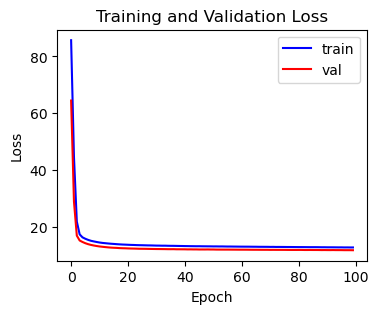

Train_MSE: 45156007.7736
Train_RSME: 6719.8220
Train_MAE: 3540.6957
Train_MAPE: 0.1162
Train_R^2: 0.8082


Test_MSE: 32214926.1716
Test_RSME: 5675.8194
Test_MAE: 3573.9456
Test_MAPE: 0.1174
Test_R^2: 0.8578


Val_MSE: 34062827.5744
Val_RSME: 5836.3368
Val_MAE: 3577.2562
Val_MAPE: 0.1168
Val_R^2: 0.8513

Learning Rate: 0.01

2344/2344 [==============================] - 6s 2ms/step


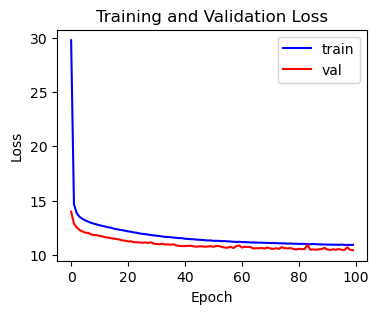

Train_MSE: 37339689.8746
Train_RSME: 6110.6211
Train_MAE: 3113.6673
Train_MAPE: 0.1034
Train_R^2: 0.8414


Test_MSE: 24442464.1233
Test_RSME: 4943.9321
Test_MAE: 3151.3376
Test_MAPE: 0.1049
Test_R^2: 0.8921


Val_MSE: 26188146.5427
Val_RSME: 5117.4355
Val_MAE: 3158.4087
Val_MAPE: 0.1044
Val_R^2: 0.8857

Learning Rate: 0.025

2344/2344 [==============================] - 6s 2ms/step


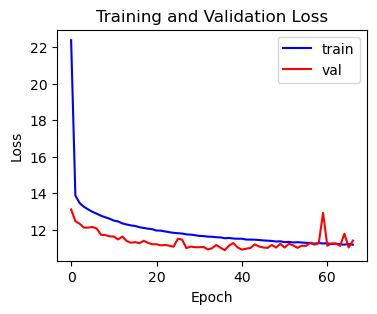

Train_MSE: 43058493.0018
Train_RSME: 6561.8971
Train_MAE: 3488.4467
Train_MAPE: 0.1129
Train_R^2: 0.8171


Test_MSE: 31103075.4531
Test_RSME: 5577.0131
Test_MAE: 3539.1529
Test_MAPE: 0.1147
Test_R^2: 0.8627


Val_MSE: 33135198.6871
Val_RSME: 5756.3182
Val_MAE: 3532.4745
Val_MAPE: 0.1140
Val_R^2: 0.8553

Learning Rate: 0.05

2344/2344 [==============================] - 6s 2ms/step


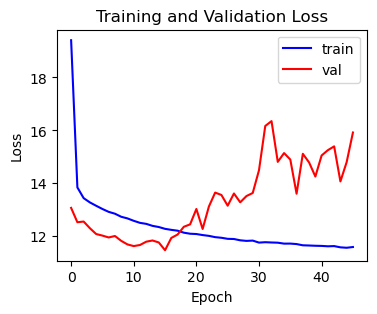

Train_MSE: 66415582.1873
Train_RSME: 8149.5756
Train_MAE: 5160.0794
Train_MAPE: 0.1589
Train_R^2: 0.7179


Test_MSE: 55154159.3232
Test_RSME: 7426.5846
Test_MAE: 5217.9283
Test_MAPE: 0.1604
Test_R^2: 0.7565


Val_MSE: 56987621.7714
Val_RSME: 7549.0146
Val_MAE: 5200.9625
Val_MAPE: 0.1592
Val_R^2: 0.7512

Learning Rate: 0.1

2344/2344 [==============================] - 6s 2ms/step


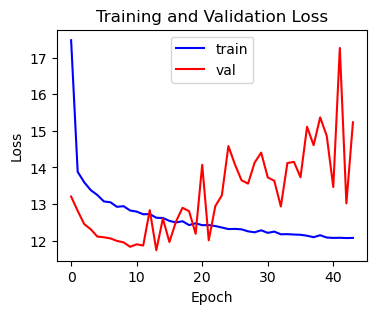

Train_MSE: 63499647.6735
Train_RSME: 7968.6666
Train_MAE: 4902.8025
Train_MAPE: 0.1524
Train_R^2: 0.7303


Test_MSE: 51648875.3223
Test_RSME: 7186.7152
Test_MAE: 4957.1260
Test_MAPE: 0.1535
Test_R^2: 0.7720


Val_MSE: 53313955.8655
Val_RSME: 7301.6406
Val_MAE: 4941.3741
Val_MAPE: 0.1523
Val_R^2: 0.7672


In [19]:
y_val_pred_list = []

for i in lr:
    output = ann1(x_train_scaled, y_train, x_test_scaled, y_test, x_val_scaled, y_val, i)
    
    print("Train_MSE: {:0.4f}".format(output[0]))
    print("Train_RSME: {:0.4f}".format(output[1]))
    print("Train_MAE: {:0.4f}".format(output[2]))
    print("Train_MAPE: {:0.4f}".format(output[3]))
    print("Train_R^2: {:0.4f}".format(output[4]))
    
    print('\n')
    
    print("Test_MSE: {:0.4f}".format(output[5]))
    print("Test_RSME: {:0.4f}".format(output[6]))
    print("Test_MAE: {:0.4f}".format(output[7]))
    print("Test_MAPE: {:0.4f}".format(output[8]))
    print("Test_R^2: {:0.4f}".format(output[9]))
    
    print('\n')
    
    print("Val_MSE: {:0.4f}".format(output[10]))
    print("Val_RSME: {:0.4f}".format(output[11]))
    print("Val_MAE: {:0.4f}".format(output[12]))
    print("Val_MAPE: {:0.4f}".format(output[13]))
    print("Val_R^2: {:0.4f}".format(output[14]))
    
    y_val_pred_list.append(output[15])

Mean Error, x = -5750.9988  y = -5750.9988
Mean Var Error, x = 240897302.2222  y = 240897302.2222


Mean Error, x = -49.1703  y = -49.1703
Mean Var Error, x = 243594298.5859  y = 243594298.5859


Mean Error, x = -4293.3707  y = -4293.3707
Mean Var Error, x = 249078280.5438  y = 249078280.5438


Mean Error, x = 6617.9304  y = 6617.9304
Mean Var Error, x = 189794684.5702  y = 189794684.5702


Mean Error, x = 2377.5148  y = 2377.5148
Mean Var Error, x = 385787833.7927  y = 385787833.7927




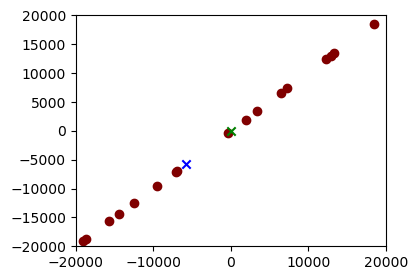

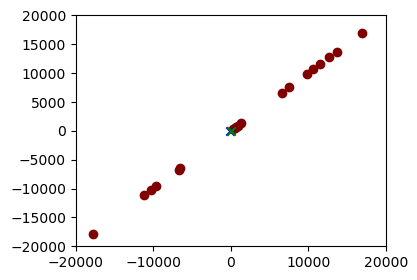

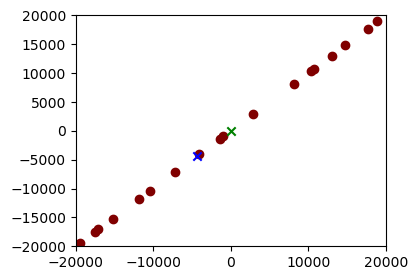

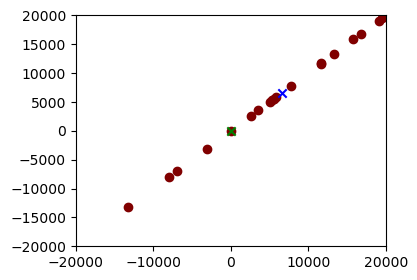

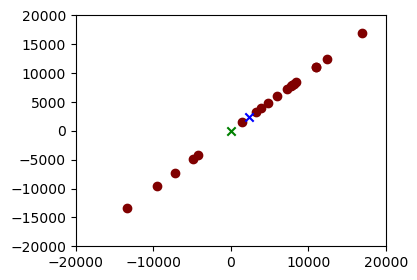

In [20]:
for i in range(len(y_val_pred_list)):
    bv = bias_variance1(y_val, y_val_pred_list[i])
    
    fig = bv[0]
    
    print("Mean Error, x = {:0.4f}".format(bv[1])," y = {:0.4f}".format(bv[2]))
    print("Mean Var Error, x = {:0.4f}".format(bv[3])," y = {:0.4f}".format(bv[4]))
    print('\n')

In [21]:
kfold  = KFold(n_splits = 10, shuffle = True, random_state = random_state)

In [22]:
kf_model = copy.deepcopy(model_list[1])

In [23]:
x_kf = copy.deepcopy(x)

In [24]:
x_kf = scaling(x_kf, y)

In [25]:
print('RUN K-FOLD, splits = 10, shuffle = True')

RUN K-FOLD, splits = 10, shuffle = True


In [26]:
fold_no = 1

for train, test in kfold.split(x_kf, y):
      
    print('\n===============================================================================================')
    print(f'Fold Number: {fold_no}')
        
    kf_model.fit(x_kf[train],y[train],
              epochs = 50,
              batch_size = 1064,
              verbose = 0)
    
    y_train_pred = kf_model.predict(x_kf[train])
    y_test_pred = kf_model.predict(x_kf[test])
        
    print('\n')
    print('Train_MSE: {:0.4f}'.format(mean_squared_error(y[train], y_train_pred)))
    print('Train_RMSE: {:0.4f}'.format(mean_squared_error(y[train], y_train_pred, squared=False)))
    print('Train_MAE: {:0.4f}'.format(mean_absolute_error(y[train], y_train_pred)))
    print('Train_MAPE: {:0.4f}'.format(mean_absolute_percentage_error(y[train], y_train_pred)))
    print('Train_R2: {:0.4f}'.format(r2_score(y[train], y_train_pred)))
    
    print('\n')
    print('Test_MSE: {:0.4f}'.format(mean_squared_error(y[test], y_test_pred)))
    print('Test_RMSE: {:0.4f}'.format(mean_squared_error(y[test], y_test_pred, squared=False)))
    print('Test_MAE: {:0.4f}'.format(mean_absolute_error(y[test], y_test_pred)))
    print('Test_MAPE: {:0.4f}'.format(mean_absolute_percentage_error(y[test], y_test_pred)))
    print('Test_R2: {:0.4f}'.format(r2_score(y[test], y_test_pred)))
    
    fold_no += 1


Fold Number: 1
2344/2344 [==============================] - 6s 3ms/step


Train_MSE: 33991247.8431
Train_RMSE: 5830.2014
Train_MAE: 3043.5085
Train_MAPE: 0.1021
Train_R2: 0.8549


Test_MSE: 24030485.4353
Test_RMSE: 4902.0899
Test_MAE: 3079.6301
Test_MAPE: 0.1034
Test_R2: 0.8957

Fold Number: 2
2344/2344 [==============================] - 6s 2ms/step


Train_MSE: 35353919.2332
Train_RMSE: 5945.9162
Train_MAE: 3046.0324
Train_MAPE: 0.1012
Train_R2: 0.8495


Test_MSE: 21940758.4878
Test_RMSE: 4684.0963
Test_MAE: 3059.7574
Test_MAPE: 0.1020
Test_R2: 0.9026

Fold Number: 3
2344/2344 [==============================] - 6s 3ms/step


Train_MSE: 35583283.0638
Train_RMSE: 5965.1725
Train_MAE: 3080.8758
Train_MAPE: 0.1016
Train_R2: 0.8488


Test_MSE: 24724171.8596
Test_RMSE: 4972.3407
Test_MAE: 3079.2430
Test_MAPE: 0.1019
Test_R2: 0.8882

Fold Number: 4
2344/2344 [==============================] - 6s 3ms/step


Train_MSE: 35288864.4913
Train_RMSE: 5940.4431
Train_MAE: 3047.0630
Train_MAPE: 0.101